This post is about my code for doing [Diffusion-limited Aggregation](https://en.wikipedia.org/wiki/Diffusion-limited_aggregation) using [NumPy](https://numpy.org/) and [Shapely](https://shapely.readthedocs.io/en/stable/).

According to Wikipedia,
>Diffusion-limited aggregation (DLA) is the process whereby particles undergoing a random walk due to Brownian motion cluster together to form aggregates of such particles.

Basically, DLA involves a bunch of particles "floating" in a "fluid", simulated using a [random walk](https://en.wikipedia.org/wiki/Random_walk), that stick to a growing group of particles when they get close enough. The result is an interesting branching pattern called a Brownian tree.
<!-- TEASER_END -->
I had found a few examples of doing DLA using Processing and Javascript, mostly using object-oriented programming to track the location and state (stuck or not) of the particles. I wanted to implement my own version in Python and specifically using NumPy, both for performance reasons and to get some more practice with using NumPy. Instead of tracking the "stuck" status of each particle in an object, I use one NumPy array to track the location of each particle and another NumPy array to indicate if each particle is stuck. This allows me to do vectorized operations using NumPy relatively easily and therefore avoid for loops.

I wanted to keep my dependencies relatively minimal for this project, so I'm using only NumPy for the calculations and Shapely to display the points at the end (which also allows exporting as SVG from the Jupyter notebook so that I could laser cut the result). You'll notice I also imported numpy.typing because I strive to use type annotations in my function definitions as much as possible and this allowed me to type the function parameters as npt.ArrayLike.

In [1]:
from shapely import Point, unary_union
import numpy as np
import numpy.typing as npt

Set the various parameters for my simulation. I set the width and height here because I initilize the particle locations to be within these dimensions. I used 10,000 particles to start, but you may want to adjust this based on your computer's performance. The particle radius is used both to determine how close particles must be to stick together. The radius will also be used when the particles are displayed.

In [2]:
NUM_PARTICLES = 10000
PARTICLE_RADIUS = 4
WIDTH = 800
HEIGHT = 800

Create a function to calculate the square of the distance between each element of 2 arrays of complex numbers. I represented the location of each particle as a [complex number](https://en.wikipedia.org/wiki/Complex_number) rather than a pair of x, y coordinates. I'm not sure if this is necessarily the easiest/best way to do it, but that's what I chose to do. You can access the real part of a complex number using the .real property and the imaginary part using the .imag property. I'm calculating the square of the distance to improve performance since square root can be a costly operation and this bascially has to run 10,000 times for each loop of the simulation.

In [3]:
def dist_squared(p1: npt.ArrayLike, p2: npt.ArrayLike):
    """Takes 2 1D arrays of complex numbers and returns the square of the distance between them."""
    p2 = p2.reshape(-1, 1)
    return (p1.real - p2.real)**2 + (p1.imag - p2.imag)**2

Generate a NumPy 1-dimensional array of 10,000 random complex numbers representing the initial locations of each particle. Append an additional particle, located at the origin, which acts as the seed particle.

Generate a second NumPy array, called *stuck*, with the same length to store whether the particle has stuck to the Brownian tree. Initialize all elements except the final element to False to indicate that they are not yet stuck. Initialize the final element in the array to True to indicate that the seed particle is "stuck".

In [4]:
# An array of complex nubmers of length NUM_PARTICLES + 1. The additional 1 is the seed placed at (0, 0)
particles = np.append(np.random.randint(-WIDTH//2, WIDTH//2, NUM_PARTICLES) +
                      np.random.randint(-HEIGHT//2, HEIGHT//2, NUM_PARTICLES) * 1j, 0 + 0j)

# An array of boolean values of the same length as paticles indicating if the particle is stuck, or part of the cluster. Only the seed particle is initialized to be True.
stuck = np.append(np.array([False for _ in range(NUM_PARTICLES)]), True)

I decided to run the simluation until 1000 particles (indicated by the `while stuck.sum() < 1000`) had stuck to the Brownian tree, but this number was selected arbitrarily and could be set at a different value. It will influence how long the simulation takes to run. As written, this took about 30 seconds to run on my machine. If you set it too high, the simulation may never complete. Try adding `print(stuck.sum())` in the while loop to follow the progress of how many particles have stuck.

In [5]:
while stuck.sum() < 1000:
    # Calculate number of particles that are not stuck
    walkers = len(particles[stuck == False])

    # Randomly walk the particles that are not currently stuck
    particles[stuck == False] += (np.random.randint(-1, 2,
                                  walkers) + np.random.randint(-1, 2, walkers) * 1j)

    # Assign the particles that are stuck to the cluster
    cluster = particles[stuck]

    # Find the square of the distance between each of the particles (including the stuck ones) and the cluster particles and compare to the square of 1.5 times the particle radius (guarantees that the particles overlap). Set the stuck variable to true if the particle is closer than the threshold to any of the cluster particles.
    stuck = (dist_squared(particles, cluster) < (1.5*PARTICLE_RADIUS)**2).any(axis=0)

I now have a NumPy array of my stuck points and can present it any way I want. I chose to keep it simple and use Shapely to present it natively in the Jupyter notebook. I planned to laser cut this result, so I created Shapely Points for each particle and then created polygons using the [buffer](https://shapely.readthedocs.io/en/stable/reference/shapely.Point.html#shapely.Point.buffer) method and then combined them using the [`unary_union`](https://shapely.readthedocs.io/en/stable/reference/shapely.unary_union.html) function to create a single polygon with all of the particles contained in it, which I can easily export as SVG and import into my laser cutter software.

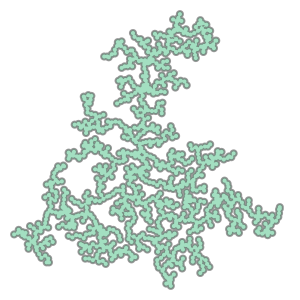

In [6]:
unary_union([Point(x.real, x.imag).buffer(PARTICLE_RADIUS)
             for x in particles[stuck]])

Here is an example of the results of this algorithm laser cut in 2 layers.

![laser-cut-dla](/images/20240211_103109.jpg)

Below is a full example using [Py5](https://py5coding.org/), a version of Processing for Python. The only changes I made from the code above were the addition of another NumPy array to track the generation that a particle gets stuck (so that it can be colored accordingly) as well as encapsulating the contents of the while loop in an `update` function and creating a means to draw the particles to the screen at each step of the simulation.

In [1]:
import py5
import numpy as np
import numpy.typing as npt

NUM_PARTICLES = 10000
PARTICLE_RADIUS = 4
WIDTH = 800
HEIGHT = 800


def dist_squared(p1: npt.ArrayLike, p2: npt.ArrayLike):
    """Takes 2 1D arrays of complex numbers and returns the square of the distance between them."""
    p2 = p2.reshape(-1, 1)
    return (p1.real - p2.real)**2 + (p1.imag - p2.imag)**2


def draw_particle(particle: complex, generation: int):
    """Draws a particle to the screen with color based on the generation."""
    # Divide the generation by 5 to make a more subtle change in color between generations. This number can be adjusted to see different results.
    py5.fill(generation//5 % 360, 1.0, 1.0)
    py5.circle(particle.real, particle.imag, 2 * PARTICLE_RADIUS)


# An array of complex nubmers of length NUM_PARTICLES + 1. The additional 1 is the seed placed at (0, 0)
particles = np.append(np.random.randint(-WIDTH//2, WIDTH//2, NUM_PARTICLES) +
                      np.random.randint(-HEIGHT//2, HEIGHT//2, NUM_PARTICLES) * 1j, 0 + 0j)

# An array of boolean values of the same length as paticles indicating if the particle is stuck, or part of the cluster. Only the seed particle is initialized to be True.
stuck = np.append(np.array([False for _ in range(NUM_PARTICLES)]), True)

# An array to track the generation when particles stick
generations = np.zeros(NUM_PARTICLES + 1)


def setup():
    py5.size(WIDTH, HEIGHT)

    # Set to the HSB color mode, which allows for nice gradual changes in color around the color wheel
    py5.color_mode(py5.HSB, 360, 1.0, 1.0)
    py5.no_stroke()


def update():
    global particles, stuck, generations

    # Calculate number of particles that are not stuck
    walkers = len(particles[stuck == False])

    # Randomly walk the particles that are not currently stuck
    particles[stuck == False] += (np.random.randint(-1, 2,
                                  walkers) + np.random.randint(-1, 2, walkers) * 1j)

    # Assign the particles that are stuck to the cluster
    cluster = particles[stuck]

    # Find the square of the distance between each of the particles (including the stuck ones) and the cluster particles and compare to the square of twice the radius. Set the stuck variable to true if the particle is closer than the threshold to any of the cluster particles.
    stuck = (dist_squared(particles, cluster)
             < (1.5*PARTICLE_RADIUS)**2).any(axis=0)

    # Increment the generation for particles that are not stuck
    generations[stuck == False] += 1


def draw():
    update()
    py5.background(0, 0, 0)
    py5.translate(py5.width//2, py5.height//2)

    # Iterate over the zipped partiles and generations arrays to draw the particles to the screen. This might have been faster to not reset the background with each draw and to only draw new particles, but I was OK with that potential performance penalty.
    [draw_particle(particle, generation) for particle,
     generation in zip(particles[stuck], generations[stuck])]


py5.run_sketch()

Additional Resources
- [The Coding Train DLA Coding Challenge](https://thecodingtrain.com/challenges/34-diffusion-limited-aggregation)
- [Form+Code DLA Example](http://formandcode.com/code-examples/simulate-dla)
- [Jason Webb Digital Morphogenesis Resources - DLA](https://github.com/jasonwebb/morphogenesis-resources#diffusion-limited-aggregation-dla)